# Method development - betas with geometric functions

09/03/20

Aims:

- Develop $\beta_{L,M}$ formalism.
- Develop corresponding numerical methods.
- Speed things up (see [low-level benchmarking notebook](https://epsproc.readthedocs.io/en/dev/tests/Low_level_bench_tests_Wigner3j_Feb2020.html)).
- Analyse geometric terms.

For individual functions, see http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_260220.ipynb

## Formalism

Following [the previous method dev notebook](), set up $\beta_{LM}$ calculations as:

\begin{eqnarray*}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{P,R',R}{E_{P-R}(\hat{e};\mu_{0})}\sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{(\mu'-\mu_{0})}{\Lambda_{R',R}(R_{\hat{n}};\mu,P,R,R')B_{L,-M}(l,l',m,m')}I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)
\end{eqnarray*}


In the previous notebook, methods were developed and tested; here, test with example matrix elements, and compare with standard results.

## Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

* pyevtk not found, VTK export not available. 


In [2]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
# dataSet = ep.readMatEle(fileIn = dataFile)
# dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.
dataSet = ep.readMatEle(fileBase = dataPath)
dataXS = ep.readMatEle(fileBase = dataPath, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning dir
D:\code\github\ePSproc\data\photoionization
Found 2 .out file(s)


*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\no2_demo_ePS.out
Expecting 1 energy points.
Expecting 3 symmetries.
Scanning CrossSection segments.
Expecting 3 DumpIdy segments.
Found 3 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 3 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning dir
D:\code\github\ePSproc\data\photoionization
Found 2 .out f

Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered

No handles with labels found to put in legend.


l                          1                            3                    
m                         -1        0         1        -1         0         1
Cont Targ Total mu                                                           
PU   SG   PU    -1  0.000000  0.00000 -6.203556  0.000000  0.000000 -2.090641
                 1 -6.203556  0.00000  0.000000 -2.090641  0.000000  0.000000
SU   SG   SU     0  0.000000  6.24652  0.000000  0.000000  2.605768  0.000000

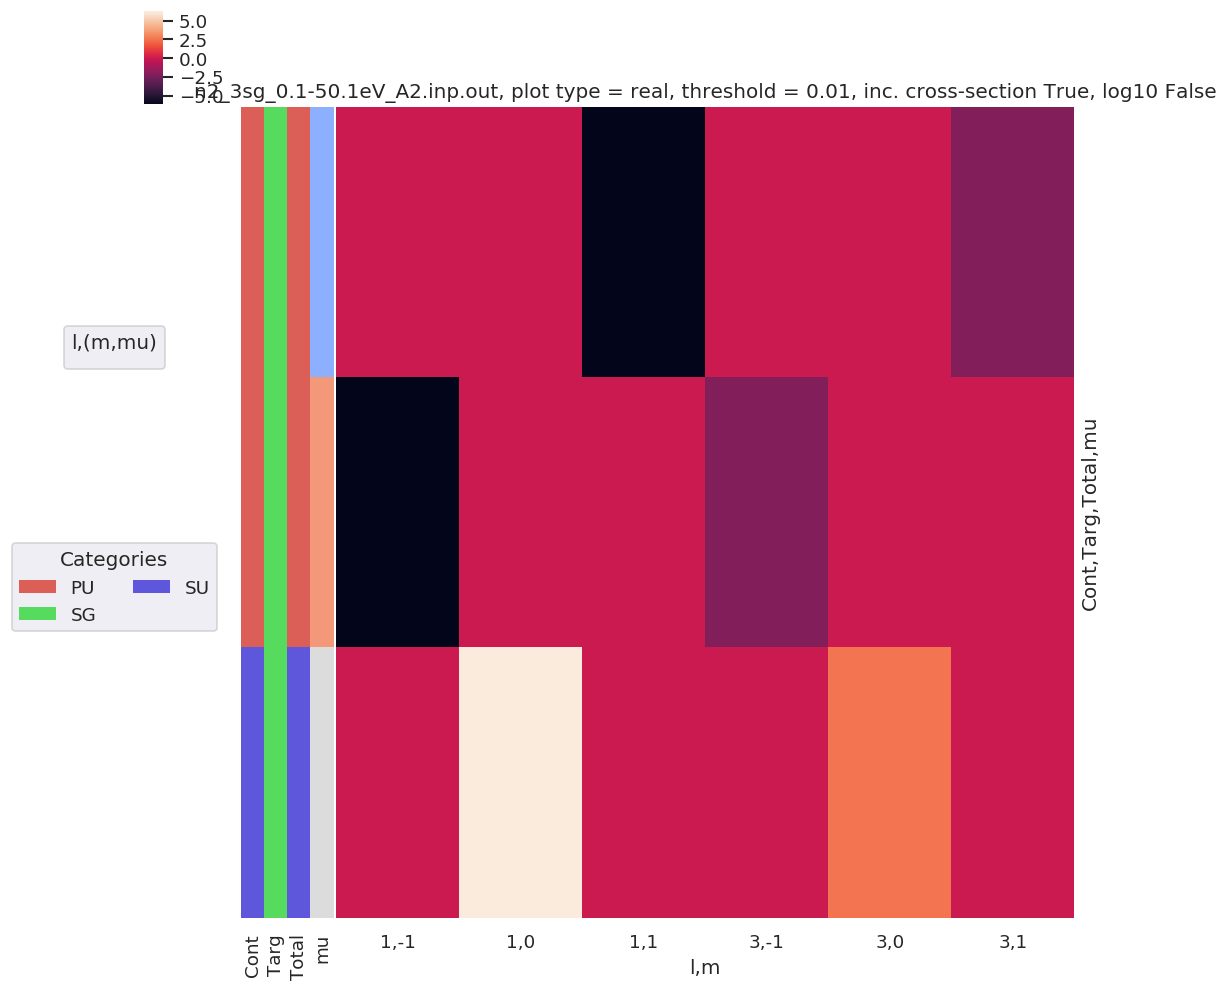

In [3]:
# Set for a single set of matrix elements for testing
dataNsel = 0
matE = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'Eke':0.1, 'it':1, 'Type':'L'})
# matE = matEleSelector(dataSet[dataNsel], thres = 1e-2, inds = {'it':1, 'Type':'L'})

# Plot vs. (l,m)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, plotDims = ['Cont', 'Targ', 'Total', 'mu'], xDim = {'LM':['l','m']}, pType = 'r')
daPlotpd

In [4]:
# Test muiltiplication by pairs...
matEconj = matE.copy().conj()
matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})

matEmult = matEconj * matE.unstack()
matEmult.attrs['dataType'] = 'multTest'

In [5]:
matEmult.coords

Coordinates:
    Ehv      float64 15.68
  * mup      (mup) int64 -1 0 1
    Type     <U1 'L'
    it       int64 1
    Eke      float64 0.1
    SF       complex128 (2.1560627+3.741674j)
  * lp       (lp) int64 1 3
  * mp       (mp) int64 -1 0 1
  * Cont     (Cont) object 'PU' 'SU'
  * Targ     (Targ) object 'SG'
  * Total    (Total) object 'PU' 'SU'
  * mu       (mu) int64 -1 0 1
  * l        (l) int64 1 3
  * m        (m) int64 -1 0 1

In [6]:
# Check individual terms and summations.
l13 = (matEconj * matE.unstack()).sel({'l':1,'m':0,'lp':3,'mp':0,'mu':0,'mup':0}).squeeze()
l31 = (matEconj * matE.unstack()).sel({'l':3,'m':0,'lp':1,'mp':0,'mu':0,'mup':0}).squeeze()

# Sum should give real valued term only in this case...
l13 + l31

<xarray.DataArray 'n2_3sg_0.1-50.1eV_A2.inp.out' (Cont: 2, Total: 2)>
array([[       nan+nanj,        nan+nanj],
       [       nan+nanj, -0.7915971 +0.j]])
Coordinates:
    Ehv      float64 15.68
    mup      int64 0
    Type     <U1 'L'
    it       int64 1
    Eke      float64 0.1
    SF       complex128 (2.1560627+3.741674j)
    mp       int64 0
  * Cont     (Cont) object 'PU' 'SU'
    Targ     <U2 'SG'
  * Total    (Total) object 'PU' 'SU'
    mu       int64 0
    m        int64 0

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


l                                    1                             3  \
m                                   -1         0         1        -1   
Cont Targ Total lp mp mu mup                                           
PU   SG   PU    1  -1 -1  1   0.000000  0.000000  3.556042  0.000000   
                       1  1   3.556042  0.000000  0.000000  0.248403   
                    1 -1 -1   0.000000  0.000000  3.556042  0.000000   
                       1 -1   3.556042  0.000000  0.000000  0.248403   
                3  -1 -1  1   0.000000  0.000000  0.248403  0.000000   
                       1  1   0.248403  0.000000  0.000000  0.368290   
                    1 -1 -1   0.000000  0.000000  0.248403  0.000000   
                       1 -1   0.248403  0.000000  0.000000  0.368290   
SU   SG   SU    1   0  0  0   0.000000  7.496043  0.000000  0.000000   
                3   0  0  0   0.000000 -0.395799  0.000000  0.000000   

l                                                 
m                                    0         1  
Cont Targ Total lp mp mu mup                      
PU   SG   PU    1  -1 -1  1   0.000000  0.248403  
                       1  1   0.000000  0.000000  
                    1 -1 -1   0.000000  0.248403  
                       1 -1   0.000000  0.000000  
                3  -1 -1  1   0.000000  0.368290  
                       1  1   0.000000  0.000000  
                    1 -1 -1   0.000000  0.368290  
                       1 -1   0.000000  0.000000  
SU   SG   SU    1   0  0  0  -0.395799  0.000000  
                3   0  0  0   0.661931  0.000000

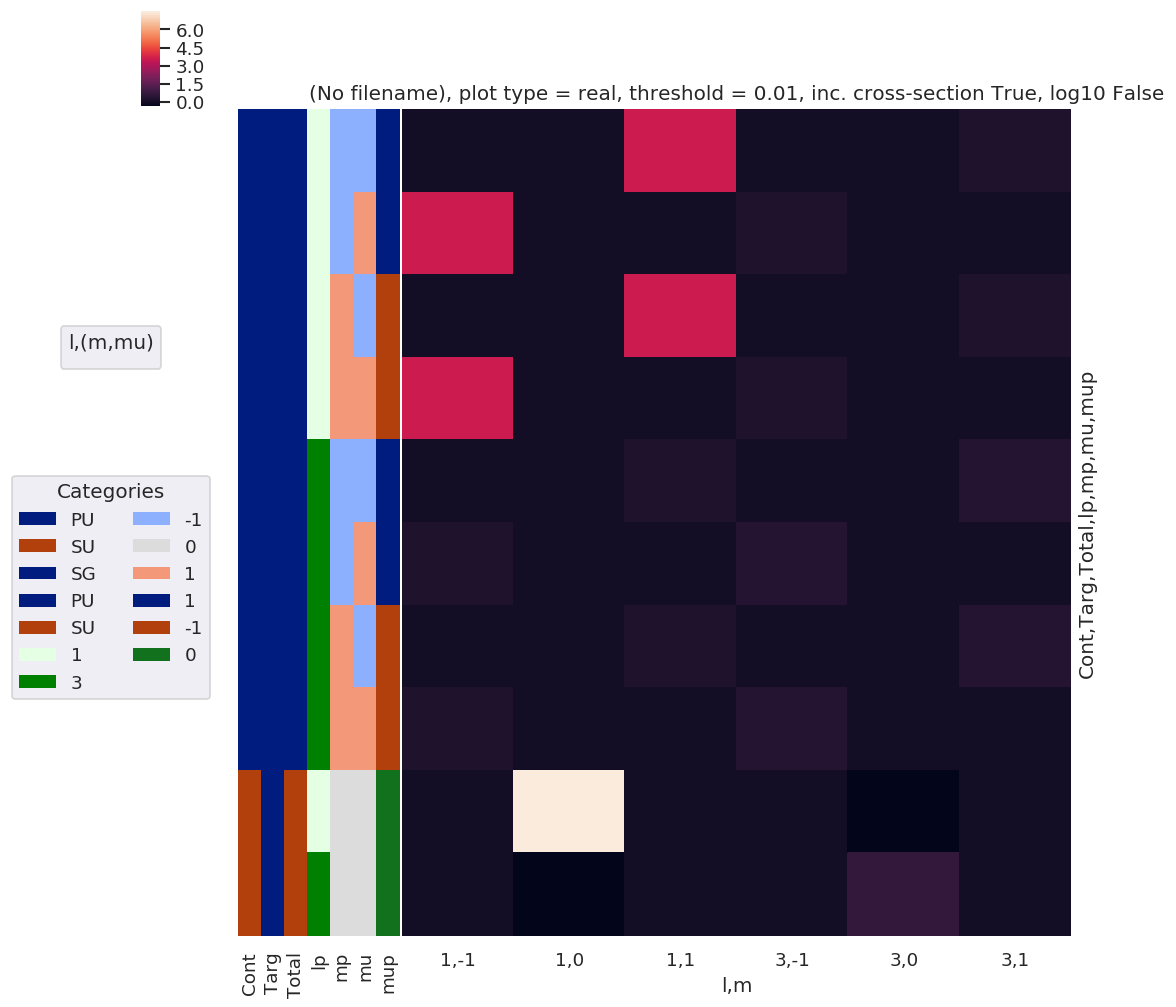

In [7]:
# Plot vs. (l,m)
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult, plotDims = ['Cont', 'Targ', 'Total', 'lp', 'mp', 'mu', 'mup'], xDim = {'LM':['l','m']}, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult, xDim = {'LM':['l','m']}, pType = 'r')
daPlotpd

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


l                           1                               3            \
m                          -1         0          1         -1         0   
Cont Targ Total mu                                                        
PU   SG   PU    -1   0.000000  0.000000  14.249028   0.000000  0.000000   
                 1  14.249028  0.000000   0.000000  13.109674  0.000000   
SU   SG   SU     0   0.000000  0.860009   0.000000   0.000000  6.170074   

l                              
m                           1  
Cont Targ Total mu             
PU   SG   PU    -1  13.109674  
                 1   0.000000  
SU   SG   SU     0   0.000000

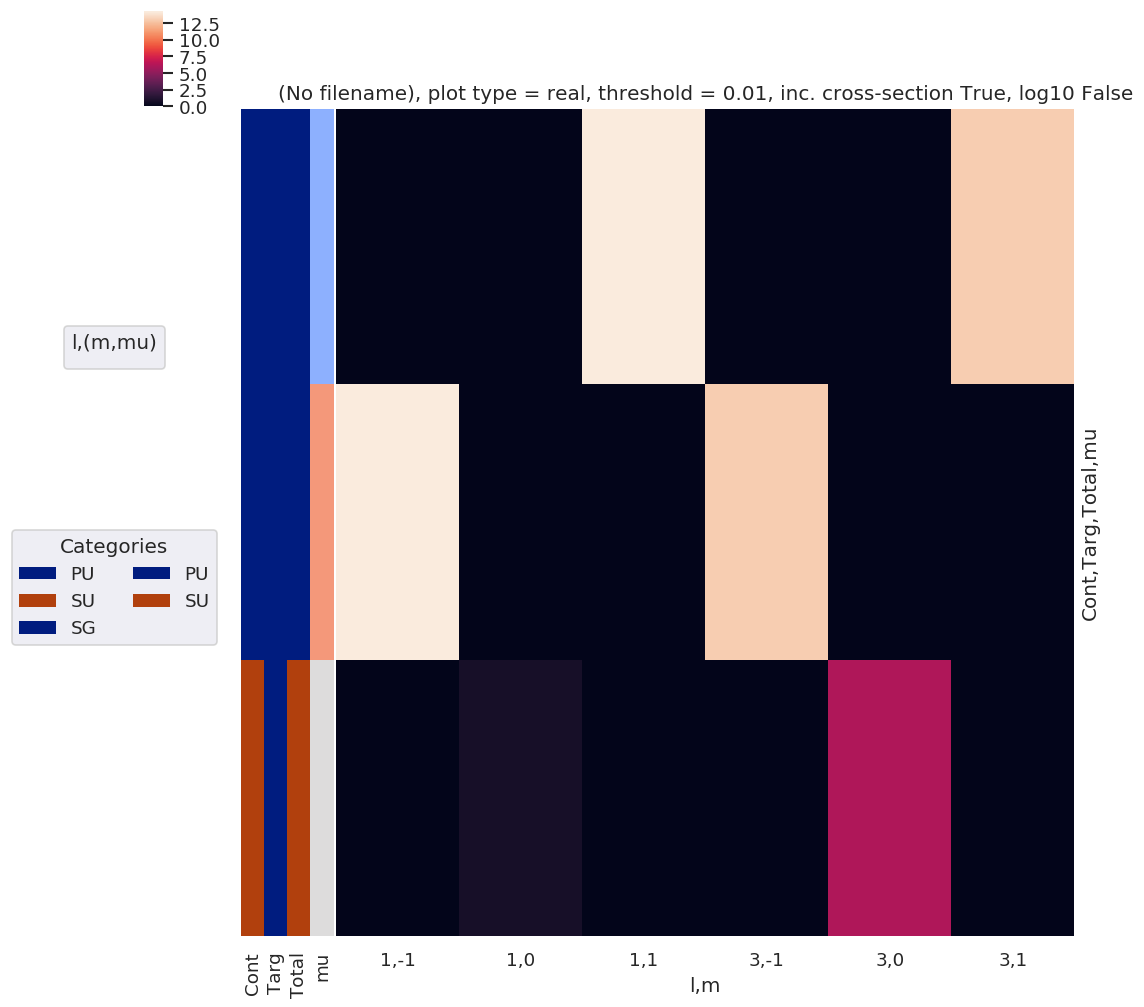

In [8]:
# Check differences...
matEdiff = matEmult.sum(['lp','mp','mup']) - matE.unstack()
matEdiff.attrs['dataType'] = 'matE'
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEdiff, plotDims = ['Cont', 'Targ', 'Total', 'mu'], xDim = {'LM':['l','m']}, pType = 'r')
daPlotpd

## Test full multiplication terms...
See also http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_260220.ipynb

In [9]:
lmax = matE.l.max()
p = [0]  # Set single pol state only - NOTE EPR() currently sets all ep=1, need to fix this!

# Calculate various tensors...

# *** EPR
EPRX = geomCalc.EPR(form = 'xarray', p = p).sel({'R-p':0})  # Set for R-p = 0 for p=0 case (redundant coord) - need to fix in e-field mult term!

# *** Blm term with specified QNs - see below...
# BLMtable = geomCalc.betaTerm(Lmax = lmax, form = 'xdaLM')  

In [10]:
# This is the method from BLMCalcLoop() for getting all LM pairs - should work here too

import pandas as pd

# LMlist = pd.MultiIndex.from_product([matE.SumDim, matE.SumDim], names = ['LM1','LM2'])
# indList = pd.MultiIndex.from_product([np.arange(0, matE.size), np.arange(0, matE.size)], names = ['ind1','ind2'])
LMlist = pd.MultiIndex.from_product([matE.LM, matE.LM], names = ['lm','lpmp']).unique()
indList = pd.MultiIndex.from_product([np.arange(0, matE.size), np.arange(0, matE.size)], names = ['ind1','ind2'])

In [11]:
# Generate 3j QNs from matE

# Code adapted from genllL() function, to generate all QNs

def genllpMatE(matE, uniqueFlag = True, mFlag = True):
    # Get QNs from matE
    lList = matE.unstack().l.values  # Use unstack here, or np.unique(matE.l), to avoid duplicates
    
    if mFlag:
        mList = matE.unstack().m.values
    else:
        mList = [0]
    
    # Set QNs for calculation, (l,m,mp)
    QNs = []
    for l in lList:
        for lp in lList:
            print([l,lp])
            for m in mList:
                for mp in mList:
                    for L in np.arange(np.abs(l-lp), l+lp+1):
                        M = -(m+mp)
                        if np.abs(M) <= L:  # Skip terms with invalid M
                            QNs.append([l, lp, L, m, mp, M])

    if uniqueFlag:
        return np.unique(QNs, axis = 0)
    else:
        return np.array(QNs)

In [12]:
QNlist = genllpMatE(matE)  # Quite slow... generates 4608x6 values in this case?  NOW FIXED WITH matE.unstack() to avoid duplicates - 128x6 terms now.

[1, 1]
[1, 3]
[3, 1]
[3, 3]


In [13]:
uniquellpL, setllpL, indllpL = np.unique(QNlist, axis = 0, return_inverse = True, return_index = True)  # Returns 128x6

In [14]:
# Test sub-functions...
BLMtable = ep.geomFunc.w3jTable(QNs = QNlist, nonzeroFlag = True, form = 'xdaLM', dlist = ['l', 'lp', 'L', 'm', 'mp', 'M'])

# try:
#     mPhase = np.power(-1, np.abs(BLMtable.m))
#     degen = (2*BLMtable.l+1)*(2*BLMtable.lp+1)*((2*BLMtable.L+1))/(4*np.pi)

#     # 3j product term
# #     BLMtable *= mPhase*np.sqrt(degen)*BLMtable.sel(m=0,mp=0,M=0)
#     BLMtable = mPhase.unstack()*np.sqrt(degen.unstack())*BLMtable.unstack() * BLMtable.unstack().sel(m=0,mp=0,M=0)

# except KeyError:
#     mPhase = np.power(-1, np.abs(BLMtable.m))
#     degen = (2*BLMtable.l+1)*(2*BLMtable.lp+1)*((2*BLMtable.L+1))/(4*np.pi)
    
#     thrj0 = ep.geomFunc.w3jTable(QNs = genllpMatE(matE, mFlag = False), nonzeroFlag = True, form = 'xdaLM', dlist = ['l', 'lp', 'L', 'm', 'mp', 'M'])
#     BLMtable = mPhase*np.sqrt(degen)*BLMtable*thrj0.drop('mSet').squeeze()

mPhase = np.power(-1, np.abs(BLMtable.m))
degen = (2*BLMtable.l+1)*(2*BLMtable.lp+1)*((2*BLMtable.L+1))/(4*np.pi)

# thrj0 = ep.geomFunc.w3jTable(QNs = genllpMatE(matE, mFlag = False), nonzeroFlag = True, form = 'xdaLM', dlist = ['l', 'lp', 'L', 'm', 'mp', 'M'])
QNsM0 = ep.geomFunc.genllpMatE(matE, mFlag = False)
thrj0 = ep.geomFunc.w3jTable(QNs = QNsM0, nonzeroFlag = True, form = 'xdaLM', dlist = ['l', 'lp', 'L', 'm', 'mp', 'M'])
BLMtable = mPhase*np.sqrt(degen)*BLMtable*thrj0.drop('mSet').squeeze()

TypeError: 'int' object is not iterable

In [ ]:
# *** Blm term with specified QNs
BLMtable = geomCalc.betaTerm(QNs = QNlist, form = 'xdaLM')

# Apply additional phase convention
BLMtableResort = BLMtable.copy().unstack()
Mphase = True
mphase = True

if Mphase:
    BLMtableResort['M'] *= -1
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.M))  # Associated phase term
    
if mphase:
    BLMtableResort['m'] *= -1
    BLMtableResort *= np.power(-1, np.abs(BLMtableResort.m))  # Associated phase term

In [ ]:
thres = 1e-4
plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtableResort, plotDims=plotDimsRed, xDim=xDim, pType = 'r', thres = thres)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMtableResort.where(np.abs(BLMtableResort)>thres).dropna('L',how='all'), plotDims=plotDimsRed, xDim=xDim, pType = 'r', thres = thres)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(ep.util.matEleSelector(BLMtableResort, thres = thres, dims=['L','M']), plotDims=plotDimsRed, xDim=xDim, pType = 'r', thres = thres)
# These are basically all equivalent, since lmPlot calls matEleSelector.

In [ ]:
# With multiplication by matE...
# BLMprod = matEmult * BLMtable.unstack()
BLMprod = matEmult * BLMtableResort  # Unstacked case with phase correction

# plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMprod, xDim=xDim, pType = 'a')

In [ ]:
# daPlotpd[daPlotpd.abs() >= 0.01].dropna(how='all', axis=1)
daPlotpd.dropna(how='all', axis=1)

In [ ]:
# Check complex values...
xDim = {'LM':['L','M']}
BLMprodpd, _ = ep.util.multiDimXrToPD(BLMprod, colDims=xDim, thres = 1e-2)
BLMprodpd

In [ ]:
# Check complex values with summation
xDim = {'LM':['L','M']}
sumDims = ['l','lp','m','mp', 'Cont', 'Targ', 'Total']
BLMprodpd, _ = ep.util.multiDimXrToPD(BLMprod.sum(sumDims), colDims=xDim, thres = 1e-2)
BLMprodpd

### Polarisation terms

In [ ]:
# *** EPR
EPRX = geomCalc.EPR(form = 'xarray', p = p).sel({'R-p':0})  # Set for R-p = 0 for p=0 case (redundant coord) - need to fix in e-field mult term!
# EPRXresort = EPRX.unstack().squeeze().drop('l').drop('lp')  # This removes photon (l,lp) dims fully. Note that squeeze() drops all singleton dims to labels here, might be an issue later...!
# EPRXresort = EPRX.unstack().drop('l').drop('lp')  # This removes photon (l,lp) dims fully, but keeps (p,R) as singleton dims.
EPRXresort = EPRX.unstack().squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

Rphase = True
if Rphase:
    EPRXresort['R'] *= -1

# *** Lambda term
lambdaTerm, lambdaTable, lambdaD, QNs = geomCalc.MFproj(form = 'xarray', phaseConvention='E')
# lambdaTermResort = lambdaTerm.squeeze().drop('l').drop('lp')   # This removes photon (l,lp) singleton dims fully.
lambdaTermResort = lambdaTerm.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

In [ ]:
polProd = EPRXresort * lambdaTermResort

# Plot all QNs vs. Euler angles (by label)
plotDimsRed = ['l', 'lp', 'P', 'mu', 'mup', 'R', 'Rp']
xDim = 'Labels'
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(polProd, plotDims=plotDimsRed, xDim=xDim, pType = 'a')   # Plot abs values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(polProd, xDim=xDim, pType = 'a')   # Plot abs values

In [ ]:
# Check complex values
xDim = 'Labels'
# plotDimsRed = ['l', 'lp', 'P', 'mu', 'mup', 'R', 'Rp']
plotDimsRed = ['P', 'mu', 'mup', 'R', 'Rp']
# polProd = polProd.drop('Euler').swap_dims({'Euler':'Labels'})
# polProd = polProd.swap_dims({'Euler':'Labels'})  # Without drop - this will keep Euler as non-dimensional label
polProdpd, _ = ep.util.multiDimXrToPD(polProd, colDims=xDim, rowDims=plotDimsRed, thres = 1e-2)
polProdpd

In [ ]:
# Check complex values, R=0 case
xDim = 'Labels'
plotDimsRed = ['l', 'lp', 'P', 'mu', 'mup', 'R', 'Rp']
polProdpd, polProdRestack = ep.util.multiDimXrToPD(polProd.sel({'R':0}), colDims=xDim, rowDims=plotDimsRed, thres = 1e-2)
polProdpd

### Test full multiplication...

In [ ]:
# Test big mult...
mTerm = polProd.sel({'R':0,'Labels':'z'}) * BLMprod.sum(['Total'])    # BLMprod.sum(['Cont', 'Targ', 'Total'])  
# Multiplication works OK, and is fast... but might be an ugly result... INDEED - result large and slow to manipulate, lots of dims and NaNs. Better to sub-select terms first!

# No subselection, mTerm.size = 6804000
# For polProd.sel({'R':0}), mTerm.size = 1360800
# For polProd.sel({'R':0,'Labels':'z'}), mTerm.size = 453600
# Adding also BLMprod.sum(['Total']), mTerm.size = 226800
# Adding also BLMprod.sum(['Cont', 'Targ', 'Total']), mTerm.size = 113400  So, for sym specific calcs, may be better to do split-apply type methods

mupPhase = True
# Set additional phase term, (-1)^(mup-p)
if mupPhase:
    mupPhaseTerm = np.power(-1, np.abs(mTerm.mup - mTerm.p))
    mTerm = mTerm * mupPhaseTerm
    
mTerm.attrs['file'] = 'MulTest'  # Temporarily adding this, not sure why this is an issue here however (not an issue for other cases...)

In [ ]:
# sumDims = ['l', 'lp', 'P', 'mu', 'mup', 'Rp', 'm', 'mp']  # Define dims to sum over
sumDims = ['P', 'mu', 'mup', 'Rp', ]  # Define dims to sum over
# selDims = {'p':0, 'R':0, 'R-p':0}  # Use selDims to select pol state
# selDims = {'R':0}  # Use selDims to select pol state
# plotDimsRed = ['L','M']
plotDimsRed = ['l', 'lp', 'm', 'mp']
# xDim = 'Labels'
xDim = {'LM':['L','M']}

# Getting dataType issue here, although was fixed????
mTerm.attrs['dataType'] = '(No dataType)'

daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTerm, plotDims=plotDimsRed, xDim=xDim, sumDims=sumDims, pType = 'a')   # Plot abs values

In [ ]:
# Replicate plotting code for complex-valued tabulation only... Need to sum & threshold first, since this is not done in the same way in multiDimXrToPD()
thres = 1e-2
mTermSum = mTerm.sum(sumDims).squeeze()
mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = xDim)
daPlotpd2, _ = ep.util.multiDimXrToPD(mTermSumThres, colDims=xDim, rowDims=plotDimsRed, thres = thres)
daPlotpd2

In [ ]:
thres = 1e-2
sumDims = ['P', 'mu', 'mup', 'Rp', 'l','lp','m','mp']  # Define dims to sum over
mTermSum = mTerm.sum(sumDims).squeeze()
mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = xDim)
daPlotpd2, _ = ep.util.multiDimXrToPD(mTermSumThres, colDims=xDim, rowDims=plotDimsRed, thres = thres)
daPlotpd2/daPlotpd2[0][0][1]

In [ ]:
thres = 1e-2
sumDims = ['P', 'mu', 'mup', 'Rp', 'l','lp','m','mp','Cont']  # Define dims to sum over
mTermSum = mTerm.sum(sumDims).squeeze()
mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = xDim)
daPlotpd2, _ = ep.util.multiDimXrToPD(mTermSumThres, colDims='M', thres = thres)
daPlotpd2/daPlotpd2[0][0].values
# mTermSumThres.unstack()

In [ ]:
# Check complex values with summation - this seems to hang???  Not sure why, since lmPlot() code doesn't.
# mTerm.size = 6804000 might be the issue!  Sometimes this is very slow (many seconds, even minutes) to return. Weird - seems intermittent.  Same for .dims method.
# Add sum & select in first!

xDim = {'LM':['L','M']}
sumDims = ['l','lp','m','mp', 'Cont', 'Targ', 'Total']
selDims = {'R':0}  # Use selDims to select pol state

thres = 1e-2
# mTerm = matEleSelector(mTerm, thres=thres, inds = selDims, dims = xDim)   # ...........hangs

In [ ]:
mTermSum = mTerm.sum(sumDims).squeeze()    # Fast...... but then get hang at mTermSum.size!  Intermittent issue? Does Xarray hand off to BG process here?
# mTermSum.size  # Eventually returned 47250
# daPlot.attrs = data.attrs  # Reset attribs

mTermSum = mTermSum.drop('Euler').swap_dims({'Euler':'Labels'})  # Also ...........slow............

In [ ]:
mTermpd, mTermRestack = ep.multiDimXrToPD(mTermSum, colDims=xDim, thres = thres)
mTermpd

In [ ]:
# Check complex values
xDim = 'Labels'
plotDimsRed = ['l', 'lp', 'P', 'mu', 'mup', 'R', 'Rp']
polProdpd, _ = ep.multiDimXrToPD(polProd.drop('Euler').swap_dims({'Euler':'Labels'}), colDims=xDim, rowDims=plotDimsRed, thres = 1e-2)
polProdpd

## Xarray Tensor products...

Might be a cleaner way to do some of the numerics... but may (accidentally) loose some X-terms?

In [ ]:
# Demo http://xarray.pydata.org/en/stable/generated/xarray.DataArray.dot.html#xarray.DataArray.dot

da_vals = np.arange(6 * 5 * 4).reshape((6, 5, 4))
da = xr.DataArray(da_vals, dims=['x', 'y', 'z'])
dm_vals = np.arange(4)
dm = xr.DataArray(dm_vals, dims=['z'])

In [ ]:
dot_result = da.dot(dm) # Dot product over z

In [ ]:
# Test with matE...
matEUS = matE.copy().unstack()

matEdot = matEUS.dot(matEUS.conj(), dims = ['lp','mp'])

In [ ]:
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult.sum(['lp','mp']), xDim = {'LM':['l','m']}, pType = 'r')
daPlot2, daPlotpd2, legendList, gFig = ep.lmPlot(matEdot, xDim = {'LM':['l','m']}, pType = 'r')

## Functionalise...

In [ ]:
def mfblmXprod(matEin, QNs = None, EPRX = None, p=[0], lambdaTerm = None, BLMtable = None, 
               thres = 1e-2, thresDims = 'Eke', 
               selDims = {'it':1, 'Type':'L'}, sumDims = ['mu', 'mup', 'l','lp','m','mp'], sumDimsPol = ['P','R','Rp','p'], symSum = True,
               SFflag = True):
    
    # Fudge - set this for now to enforce additonal unstack and phase corrections later.
    BLMtableResort = None
    
    # Threshold and selection
    # Make explicit copy of data to avoid any overwrite issues
    matE = matEin.copy()
    matE.attrs = matEin.attrs  # May not be necessary with updated Xarray versions

    # Use SF (scale factor)
    # Write to data.values to make sure attribs are maintained. (Not the case for da = da*da.SF)
    if SFflag:
        matE.values = matE * matE.SF
        
    if symSum:
        matE = matE.sum('Sym')  # Sum over ['Cont','Targ','Total'] stacked dims.
        
    matEthres = ep.util.matEleSelector(matE, thres = thres, inds = selDims, dims = thresDims)
    
    # Set terms if not passed to function
    if QNs is None:
        QNs = genllpMatE(matEthres)
    
    #*** Polarization terms
    if EPRX is None:
        # *** EPR
#         EPRX = geomCalc.EPR(form = 'xarray', p = p).sel({'R-p':0})  # Set for R-p = 0 for p=0 case (redundant coord) - need to fix in e-field mult term!
        # EPRXresort = EPRX.unstack().squeeze().drop('l').drop('lp')  # This removes photon (l,lp) dims fully. Be careful with squeeze() - sends singleton dims to non-dimensional labels.
#         EPRXresort = EPRX.unstack().drop('l').drop('lp')  # This removes photon (l,lp) dims fully, but keeps (p,R) as singleton dims.
#         EPRXresort = EPRX.unstack().squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.
    
#         EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sum(['p','R-p'])  # Set for general sum over (p,R-p) terms - STILL need to fix in e-field mult term!
#         EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sum('R-p')  # Set for general sum over (p,R-p) terms - STILL need to fix in e-field mult term!
        EPRX = geomCalc.EPR(form = 'xarray', p = p).unstack().sel({'R-p':0}).drop('R-p')
        EPRXresort = EPRX.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

        Rphase = True
        if Rphase:
            EPRXresort['R'] *= -1
            
    if lambdaTerm is None:
        # *** Lambda term
        lambdaTerm, lambdaTable, lambdaD, _ = geomCalc.MFproj(form = 'xarray', phaseConvention='E')
#         lambdaTermResort = lambdaTerm.squeeze().drop('l').drop('lp')   # This removes photon (l,lp) dims fully.
        lambdaTermResort = lambdaTerm.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.
    
    # *** Blm term with specified QNs
    if BLMtable is None:
        BLMmPhase = False
        QNsBLMtable = QNs.copy()
        if BLMmPhase:
            QNsBLMtable[:,3] *= -1
            QNsBLMtable[:,5] *= -1
        
        BLMtable = geomCalc.betaTerm(QNs = QNsBLMtable, form = 'xdaLM')
        
#         if BLMmPhase:
#             BLMtable['m'] *= -1
     
    if BLMtableResort is None:
        # Apply additional phase convention
        BLMtableResort = BLMtable.copy().unstack()
        Mphase = True
        mphase = False

#         if BLMmPhase:
#             BLMtableResort['m'] *= -1  # Sign flip to undo m > -m setting in betaTerm calc.
#             BLMtableResort['M'] *= -1  # Sign flip to undo m > -m setting in betaTerm calc.
        
        if Mphase:
            BLMtableResort['M'] *= -1
            BLMtableResort *= np.power(-1, np.abs(BLMtableResort.M))  # Associated phase term

        if mphase:
            BLMtableResort['m'] *= -1
            BLMtableResort *= np.power(-1, np.abs(BLMtableResort.m))  # Associated phase term
            
        
            
    #*** Thresholding & dim dropping...
    # To minimize ND size
    # Q: can use matEleSelector here, but might be an issue with large arrays due to copying.
    # Using xr.where() directly should prevent array copy.
    
    matEmax = matEthres.max()  # Set as a scale factor for later
    thresScaled = matEmax * thres
    
    BLMtableResort = ep.util.matEleSelector(BLMtableResort, thres=thresScaled)  # Reduce size before big multiplication
    
    
    #*** Products
    # Matrix element pair-wise multiplication by (l,m,mu) dims
    matEconj = matEthres.copy().conj()
    matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})
    matEmult = matEconj * matEthres.unstack()
    matEmult.attrs['dataType'] = 'multTest'
        
    # Threshold product and drop dims.
    matEmult = ep.util.matEleSelector(matEmult, thres = thres, dims = thresDims)
    
    # Product terms with similar dims
    BLMprod = matEmult * BLMtableResort  # Unstacked case with phase correction
    # polProd = (EPRXresort * lambdaTermResort).sum(sumDimsPol)  # Sum polarization terms here to keep total dims minimal in product. Here dims = (mu,mup,Euler/Labels)
    polProd = (EPRXresort * lambdaTermResort)  # Without polarization terms sum to allow for mupPhase below (reqs. p)
    
    mupPhase = True 
    # Set additional phase term, (-1)^(mup-p)  **** THIS MIGHT BE SPURIOUS FOR GENERAL EPR TENSOR CASE??? Not sure... but definitely won't work if p summed over above!
    if mupPhase:
        mupPhaseTerm = np.power(-1, np.abs(polProd.mup - polProd.p))
#         mupPhaseTerm = np.power(-1, np.abs(mTerm.mup - mTerm.p))
#         mupPhaseTerm = np.power(-1, np.abs(mTerm.mup))   # TESTING ONLY, with p already summed over... WITHOUT THIS PU cont (N2 test case) becomes -ve!
        polProd *= mupPhaseTerm
    
    polProd = polProd.sum(sumDimsPol)
    
    
    # Test big mult...
#     mTerm = polProd.sel({'R':0,'Labels':'z'}) * BLMprod.sum(['Total'])    # With selection of z geom.  # BLMprod.sum(['Cont', 'Targ', 'Total'])  
#     mTerm = polProd.sel({'R':0}) * BLMprod.sum(['Total'])    # BLMprod.sum(['Cont', 'Targ', 'Total'])  
    mTerm = polProd * BLMprod
    # Multiplication works OK, and is fast... but might be an ugly result... INDEED - result large and slow to manipulate, lots of dims and NaNs. Better to sub-select terms first!

    # No subselection, mTerm.size = 6804000
    # For polProd.sel({'R':0}), mTerm.size = 1360800
    # For polProd.sel({'R':0,'Labels':'z'}), mTerm.size = 453600
    # Adding also BLMprod.sum(['Total']), mTerm.size = 226800
    # Adding also BLMprod.sum(['Cont', 'Targ', 'Total']), mTerm.size = 113400  So, for sym specific calcs, may be better to do split-apply type methods

#     mupPhase = True 
#     # Set additional phase term, (-1)^(mup-p)  **** THIS MIGHT BE SPURIOUS FOR GENERAL EPR TENSOR CASE??? Not sure... but definitely won't work if p summed over above!
#     if mupPhase:
# #         mupPhaseTerm = np.power(-1, np.abs(mTerm.mup - mTerm.p))
#         mupPhaseTerm = np.power(-1, np.abs(mTerm.mup))   # TESTING ONLY, with p already summed over... WITHOUT THIS PU cont (N2 test case) becomes -ve!
#         mTerm = mTerm * mupPhaseTerm

    mTerm.attrs['file'] = 'MulTest'  # Temporarily adding this, not sure why this is an issue here however (not an issue for other cases...)
    
    
    # Sum and threshold
#     sumDims = ['P', 'mu', 'mup', 'Rp', ]  # Define dims to sum over
    xDim = {'LM':['L','M']}
    mTermSum = mTerm.sum(sumDims).squeeze()
    mTermSumThres = matEleSelector(mTermSum.stack(xDim), thres=thres, dims = thresDims)
#     mTermSumThres = mTermSum
    
    # Normalise
    # TODO: Set XS as per old mfpad()
#     BLMXout['XS'] = (('Eke','Euler'), BLMXout[0].data)  # Set XS = B00
#     BLMXout = BLMXout/BLMXout.XS  # Normalise
    mTermSumThres['XS'] = mTermSumThres.sel({'L':0,'M':0}).drop('LM').copy()  # This basically works, and keeps all non-summed dims. Make sure to .copy(), otherwise it's just a pointer.
    mTermSumThres /=  mTermSumThres['XS']    # mTermSumThres.sel({'L':0,'M':0}).drop('LM')
    mTermSumThres.attrs['dataType'] = 'multTest'
    
    return mTermSumThres, mTermSum, mTerm
    

In [ ]:
# Test fn
mTermST, mTermS, mTermTest = mfblmXprod(matE, QNs = None, selDims = None, thresDims= None)

In [ ]:
# Full results (before summation)
plotDimsRed = ['l', 'lp', 'm', 'mp']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermTest, plotDims=None, xDim=xDim, sumDims=None, pType = 'a')   # Plot abs values

In [ ]:
# Table is too big, not very useful!
mTermTestpd, _ = ep.util.multiDimXrToPD(mTermTest, colDims=xDim, thres = 1e-2, dropna=True)
mTermTestpd # .dropna(how='all', axis=0)

In [ ]:
# Check summed terms, OK - NOTE this needs stack() first
mTermpd, mTermRestack = ep.util.multiDimXrToPD(mTermS.stack(xDim), colDims=xDim, thres = 1e-2)
mTermpd

### TEST VS. E and/or pol geom... NOTEBOOK VERSION
Looks good.

- mTermST, mTermS, mTermTest = mfblmXprod(dataSet[0], QNs = None, thres = 1e-2, selDims = {'it':1, 'Type':'L'}, thresDims= None)
~12s

- mTermST, mTermS, mTermTest = mfblmXprod(dataSet[0], QNs = None, thres = 1e-4, selDims = {'it':1, 'Type':'L'}, thresDims= None)
~24s

Note high RAM useage, ~5-8Gb in latter case.  Might be nicer (and faster?) to group by (Eke, pol) and parallelize?

In [ ]:
import time

symSum = True

start = time.time()
mTermST, mTermS, mTermTest = mfblmXprod(dataSet[0], QNs = None, thres = 1e-2, selDims = {'it':1, 'Type':'L'}, thresDims= None, symSum=symSum)
end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points.'.format((end-start), mTermST.Eke.size))

In [ ]:
# Full results (before summation)
# plotDimsRed = ['l', 'lp', 'm', 'mp']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=['Cont','L','M'], xDim='Eke', sumDims=None, pType = 'a')   # Plot abs values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, xDim='Eke', sumDims=None, pType = 'a', thres = 0.01)   # BUG - this isn't working in this case???  Fails during pd conversion. NOW FIXED - set() and list() type issue!

In [ ]:
# Full results (before summation)
plotDimsRed = ['Labels','Cont','L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'r')   # Plot abs values

In [ ]:
# mTermST.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
if symSum:
    mTermST.XS.real.squeeze().plot.line(x='Eke', col='Labels');
    mTermST.XS.pipe(np.abs).squeeze().plot.line(x='Eke', col='Labels');
    
else:
    mTermST.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
    mTermST.XS.sum(['Cont', 'Total']).pipe(np.abs).squeeze().plot.line(x='Eke', col='Labels');


In [ ]:
if symSum:
    ep.util.matEleSelector(mTermST, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');
else:
    ep.util.matEleSelector(mTermST.sum(['Cont', 'Total']), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');

In [ ]:
# Full results (before summation)
plotDimsRed = ['Labels', 'L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'a')   # Plot abs values

In [ ]:
# Full results with Cont summation
plotDimsRed = ['Labels','L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims='Cont', pType = 'a')   # Plot abs values

In [ ]:
mTermpd, mTermRestack = ep.util.multiDimXrToPD(mTermST, colDims='Eke', thres = None)
mTermpd.fillna(0)

### TEST VS. E and/or pol geom... PACKAGE VERSION

24/03/20 - package version now includes setPhaseConventions() for easier testing.

In [ ]:
# Reload if necessary - WORKS in SPYDER, but not in Jupyter Lab?
# from importlib import reload # Python 3.4+ only.
# # import epsproc.util as epUtil

# # epUtil = reload(epUtil)
# ep = reload(ep)

### Setup

In [ ]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

In [ ]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
# dataSet = ep.readMatEle(fileIn = dataFile)
# dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.
dataSet = ep.readMatEle(fileBase = dataPath)
dataXS = ep.readMatEle(fileBase = dataPath, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

### Test phase conventions (or use geomFunc.setPhaseConventions)

In [ ]:
def setPhaseConventions(phaseConvention = 'S', typeList = False):
    """
    Set phase convention/choices for geometric functions.

    20/03/20 - first attempt. Aim to centralise all phase choices here to keep things clean and easy to debug/change.

    Set as dictionary for each term, to be appended to results Xarray.


    Parameters
    ----------

    phaseConvention : optional, str, default = 'S'
        Set phase conventions:
        - 'S' : Standard derivation.
        - 'R' : Reduced form geometric tensor derivation.
        - 'E' : ePolyScat, may have additional changes in numerics, e.g. conjugate Wigner D.

    typeList : optional, bool, default = False
        If true, return list of supported options instead of list of phase choices.

    """

    # Return just typeList if option set - this also defines master list.
    if typeList:
        # Supported types
        typeList = ['S', 'R', 'E']
        return typeList


    # Set master dict to hold choices.
    phaseCons = {'phaseConvention':phaseConvention}

    #**** For generating QNs with genllpMatE()
    # Set here to avoid issues with dropped/missing terms later!
    # Some conventions will be tied to other choices below.
    genMatEcons = {}
    if phaseConvention == 'S':
        genMatEcons['negm'] = False     # Set -m, corresponding to M = -m + mp, otherwise M = -(m+mp)
        genMatEcons['negM'] = False     # Set -M

    elif phaseConvention == 'R':
        genMatEcons['negm'] = False     # Set -m, corresponding to M = -m + mp, otherwise M = -(m+mp)
        genMatEcons['negM'] = False     # Set -M

    elif phaseConvention == 'E':
        genMatEcons['negm'] = False     # Set -m, corresponding to M = -m + mp, otherwise M = -(m+mp)
        genMatEcons['negM'] = False     # Set -M

    phaseCons['genMatEcons'] = genMatEcons
    
    #*** For EPR tensor
    EPRcons = {}
    if phaseConvention == 'S':
        EPRcons['Rphase'] = True        # Apply (-1)^R phase?
        EPRcons['negR'] = True          # Use -R or +R in 3j?
        EPRcons['negRlabel'] = False    # Use -R or +R in QN labels? (Will affect Xarray-based calculations.)
        EPRcons['negRcoordSwap'] = False    # Swap -R and +R in QN coords? (Will affect Xarray-based calculations.)

    elif phaseConvention == 'R':
        EPRcons['Rphase'] = True       # Apply (-1)^R phase?
        EPRcons['negR'] = True          # Use -R or +R in 3j?
        EPRcons['negRlabel'] = False    # Use -R or +R in QN labels? (Will affect Xarray-based calculations.)
        EPRcons['negRcoordSwap'] = False    # Swap -R and +R in QN coords? (Will affect Xarray-based calculations.)

    elif phaseConvention == 'E':
        EPRcons['Rphase'] = True        # Apply (-1)^R phase?
        EPRcons['negR'] = True          # Use -R or +R in 3j?
        EPRcons['negRlabel'] = False    # Use -R or +R in QN labels? (Will affect Xarray-based calculations.)
        EPRcons['negRcoordSwap'] = False    # Swap -R and +R in QN coords? (Will affect Xarray-based calculations.)

    phaseCons['EPR'] = EPRcons

    #*** For Lambda term (as set by MFproj())
    lambdaCons = {}
    if phaseConvention == 'S':
        lambdaCons['negMup'] = True     # Use -mup term in 3j?
        lambdaCons['phaseNegR'] = True  # Set for (-Rp, -R) phase convention (in Wigner D term)?
        lambdaCons['conjFlag'] = False  # Set for conjuate Wigner D?
        lambdaCons['RpPhase'] = True    # Apply (-1)^Rp phase term?

    elif phaseConvention == 'R':
        lambdaCons['negMup'] = True     # Use -mup term in 3j?
        lambdaCons['phaseNegR'] = True  # Set for (-Rp, -R) phase convention (in Wigner D term)?
        lambdaCons['conjFlag'] = False  # Set for conjuate Wigner D?
        lambdaCons['RpPhase'] = True    # Apply (-1)^Rp phase term?

    elif phaseConvention == 'E':
        lambdaCons['negMup'] = True     # Use -mup term in 3j?
        lambdaCons['phaseNegR'] = True  # Set for (-Rp, -R) phase convention (in Wigner D term)?
        lambdaCons['conjFlag'] = True  # Set for conjuate Wigner D?
        lambdaCons['RpPhase'] = True    # Apply (-1)^Rp phase term?

    phaseCons['lambdaCons'] = lambdaCons


    #*** For Beta term (as set by betaTerm())
    betaCons = {}
    if phaseConvention == 'S':
        betaCons['negM'] = False       # Use -M term in 3j?
        betaCons['mPhase'] = True     # Apply (-1)^m phase term?

    elif phaseConvention == 'R':
        betaCons['negM'] = False       # Use -M term in 3j?
        betaCons['mPhase'] = True     # Apply (-1)^m phase term?

    elif phaseConvention == 'E':
        betaCons['negM'] = genMatEcons['negm']       # Use -M term in 3j?
        betaCons['mPhase'] = True     # Apply (-1)^m phase term?

    phaseCons['betaCons'] = betaCons


    #*** For MFPAD product case, as calculated in mfblmXprod()
    mfblmCons = {}
    if phaseConvention == 'S':
        mfblmCons['negRcoordSwap'] = True       # Swap -R and +R in EPR Xarray coords?

        mfblmCons['negMcoordSwap'] = True       # Swap +/-M coords.
        mfblmCons['Mphase'] = True              # Apply (-1)^M phase term.

        mfblmCons['negmCoordSwap'] = True       # Swap +/-m coords.
        mfblmCons['mPhase'] = True              # Apply (-1)^m phase term.

        mfblmCons['mupPhase'] = True            # Apply (-1)^(mup - p) phase term.

        mfblmCons['BLMmPhase'] = False          # TESTING ONLY - switch signs (m, M) terms before 3j calcs.

    if phaseConvention == 'R':
        mfblmCons['negRcoordSwap'] = True       # Swap -R and +R in EPR Xarray coords?

        mfblmCons['negMcoordSwap'] = False       # Swap +/-M coords.
        mfblmCons['Mphase'] = False              # Apply (-1)^M phase term.

        mfblmCons['negmCoordSwap'] = True       # Swap +/-m coords.
        mfblmCons['mPhase'] = True              # Apply (-1)^m phase term.

        mfblmCons['mupPhase'] = True            # Apply (-1)^(mup - p) phase term.

        mfblmCons['BLMmPhase'] = False          # TESTING ONLY - switch signs (m, M) terms before 3j calcs.

    if phaseConvention == 'E':
        mfblmCons['negRcoordSwap'] = True       # Swap -R and +R in EPR Xarray coords?

        mfblmCons['negMcoordSwap'] = False       # Swap +/-M coords.
        mfblmCons['Mphase'] = betaCons['negM']              # Apply (-1)^M phase term.

        mfblmCons['negmCoordSwap'] = False       # Swap +/-m coords.
        mfblmCons['mPhase'] = False              # Apply (-1)^m phase term.

        mfblmCons['mupPhase'] = True            # Apply (-1)^(mup - p) phase term. REQUIRED for physical results! (Get -ve XS otherwise)

        mfblmCons['BLMmPhase'] = False          # TESTING ONLY - switch signs (m, M) terms before 3j calcs.

    phaseCons['mfblmCons'] = mfblmCons

    return phaseCons

### GeomFunc calculation

In [ ]:
import time

symSum = True
thres = 1e-2
SFflag = False
selDims = {'it':1, 'Type':'L'} # , 'Total':'SU'}

start = time.time()
# mTermST, mTermS, mTermTest = ep.geomFunc.mfblmXprod(dataSet[0], QNs = None, thres = thres, selDims = selDims, thresDims= None, symSum=symSum, SFflag = True, phaseConvention='E')

phaseCons = setPhaseConventions('E')  # Local test version.
# phaseCons = ep.geomFunc.setPhaseConventions('E')  # Pkg version.

RX = ep.setPolGeoms()  # .swap_dims({'Euler':'Labels'}).sel({'Labels':'z'})  # Preset pol geom
mTermST, mTermS, mTermTest = ep.geomFunc.mfblmXprod(dataSet[0], QNs = None, RX = RX, thres = thres, selDims = selDims, thresDims= None, symSum=symSum, SFflag = SFflag, phaseConvention=phaseCons)

end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points.'.format((end-start), mTermST.Eke.size))

In [ ]:
# Full results (before summation)
# plotDimsRed = ['l', 'lp', 'm', 'mp']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=['Cont','L','M'], xDim='Eke', sumDims=None, pType = 'a')   # Plot abs values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, xDim='Eke', sumDims=None, pType = 'a', thres = 0.01)   # BUG - this isn't working in this case???  Fails during pd conversion. NOW FIXED - set() and list() type issue!

In [ ]:
# Full results (before summation)
plotDimsRed = ['Labels','Cont','L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermS, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'r')   # Plot abs values

In [ ]:
# mTermST.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
if symSum:
    if mTermST.Labels.size == 1:
        mTermST.XS.real.squeeze().plot.line(x='Eke');
        mTermST.XS.pipe(np.abs).squeeze().plot.line(x='Eke');
    else:
        mTermST.XS.real.squeeze().plot.line(x='Eke', col='Labels');
        mTermST.XS.pipe(np.abs).squeeze().plot.line(x='Eke', col='Labels');
    
else:
    mTermST.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
    mTermST.XS.sum(['Cont', 'Total']).pipe(np.abs).squeeze().plot.line(x='Eke', col='Labels');


In [ ]:
if symSum:
    if mTermST.Labels.size == 1:
        ep.util.matEleSelector(mTermST, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke');
    else:
        ep.util.matEleSelector(mTermST, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');
else:
    ep.util.matEleSelector(mTermST.sum(['Cont', 'Total']), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');

In [ ]:
# Full results (before summation)
plotDimsRed = ['Labels', 'L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermS, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'a')   # Plot abs values

In [ ]:
# Full results with Cont summation
plotDimsRed = ['Labels','L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims='Cont', pType = 'a')   # Plot abs values

In [ ]:
mTermpd, mTermRestack = ep.util.multiDimXrToPD(mTermST, colDims='Eke', thres = None)
mTermpd.fillna(0)

## Test vs. existing calcs

In [ ]:
import time
daIn = dataSet[0].copy()

# BLMXeN2 = ep.mfblm(daIn[:, 1:4], selDims = {'Type':'L'}, thres = 1e-4)       # Subselected on Eke
# start = time.time()
# BLMXeN2 = ep.mfblm(daIn, selDims = {'Type':'L'}, thres = 1e-2, verbose = False)   # Run for all Eke
# end = time.time()
# print('Elapsed time = {0} seconds, for {1} energy points.'.format((end-start), BLMXeN2.Eke.size))

# Set standard pol geoms (== (z,x,y) as used above)
eAngs = ep.setPolGeoms()

# Calculate for each pol geom
start = time.time()
BLM = ep.mfblmEuler(dataSet[0], selDims=selDims, eAngs = eAngs, thres = thres, SFflag = True, verbose = 0)  # Run for all Eke.  Note this fails if selDims = None, to fix!
end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points.'.format((end-start), BLM.Eke.size))

In [ ]:
BLMXeN2.where(np.abs(BLMXeN2)>thres, drop=True).sel({'Eke':0.1})

In [ ]:
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BLMXeN2.swap_dims({'Euler':'Labels'}), SFflag = False, eulerGroup = True)

In [ ]:
daPlotpd2/daPlotpd2[0][0][1]  # Normalised BLMs match for SU case... but PU hasn't gone to zero - missing/incorrect phase term somewhere...?  Will be in mu or m.
                            # With (-1)^m phase included get B00=Nan for PU case, but not for B2,+/-2... but maybe this is OK?
    
# TO DO
# (-1)^m *IS* in BLM
# CHECK: BLMtable = geomCalc.betaTerm(QNs = QNlist, form = 'xdaLM')

# Vs. terms in MFBLMCalcLoop()
# gammaLM = Wigner3jCached(l1, l2, L, 0, 0, 0) * Wigner3jCached(l1, l2, L, -m1, m2, -M)
# phase = (-1)**M *(-1)**m1 * (-1)**(mu2-p)
# degen = np.sqrt(((2*l1+1)*(2*l2+1)*(2*L+1))/(4*np.pi))

# Should pinpoint any accidental phase switches

In [ ]:
# Check symmetries...
BLMXeN2SU = ep.mfblm(daIn, selDims = {'Type':'L', 'Cont':'SU'}, thres = 1e-2, verbose = False)   # Run for all Eke
BLMXeN2PU = ep.mfblm(daIn, selDims = {'Type':'L', 'Cont':'PU'}, thres = 1e-2, verbose = False)   # Run for all Eke

In [ ]:
BLMXeN2SU.where(np.abs(BLMXeN2SU)>thres, drop=True).sel({'Eke':0.1})

In [ ]:
# BLMXeN2PU.where(np.abs(BLMXeN2PU)>thres, drop=True).sel({'Eke':0.1})
BLMXeN2PU.sel({'Eke':0.1})

### Test vs. NO2 case

In [ ]:
import time

start = time.time()
mTermST, mTermS, mTermTest = mfblmXprod(dataSet[1], QNs = None, thres = 1e-4, selDims = {'it':1, 'Type':'L'}, thresDims= None, symSum=False)
end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points.'.format((end-start), mTermST.Eke.size))

In [ ]:
# Full results (before summation)
# plotDimsRed = ['l', 'lp', 'm', 'mp']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=['Cont','L','M'], xDim='Eke', sumDims=None, pType = 'a')   # Plot abs values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, xDim='Eke', sumDims=None, pType = 'a', thres = 0.01)   # BUG - this isn't working in this case???  Fails during pd conversion. NOW FIXED - set() and list() type issue!

In [ ]:
# Full results (before summation)
plotDimsRed = ['Labels','Cont','L','M']
# xDim = 'Labels'
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'r')   # Plot abs values

In [ ]:
# mTermST.XS.sum(['Cont', 'Total']).real.squeeze().plot.line(x='Eke', col='Labels');
mTermST.stack({'Sym':['Cont','Total']}).XS.real.squeeze().plot.line(x='Eke', col='Labels');
mTermST.XS.sum(['Cont', 'Total']).pipe(np.abs).squeeze().plot.line(x='Eke', col='Labels');


In [ ]:
ep.util.matEleSelector(mTermST.sum(['Cont', 'Total']), thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Labels');